# APS360 Group Project

In [1]:
from generate_dataset import main
main()

Generated images for font arial
Generated images for font arialbd
Generated images for font arialbi
Generated images for font ariali
Generated images for font ariblk
Generated images for font bahnschrift
Generated images for font calibri
Generated images for font calibrib
Generated images for font calibrii
Generated images for font calibril


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import SubsetRandomSampler
from torch.utils.data.dataloader import default_collate
import os

In [3]:
print(torch.cuda.is_available())
device = "cuda:0" if torch.cuda.is_available() else "cpu"


True


## Dataset Loading

In [4]:
FONT_DATASET_PATH = "./fonts_image_dataset"

def custom_collate_fn(batch):
    
    # Use the default collate function to batch the data (images)
    batch = default_collate(batch)
    images, labels = batch
    
    # Apply one-hot encoding to the labels
    labels = F.one_hot(labels)

    return images, labels

def load_dataset(dataset_path, batch_size):

    # Convert the images to tensors and normalize them
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.Grayscale(num_output_channels=1)])
    dataset = torchvision.datasets.ImageFolder(root = dataset_path, transform=transform)

    # Create a list of indices for all the images in the dataset
    dataset_size = len(dataset)
    indices = list(range(dataset_size))

    np.random.seed(0)
    np.random.shuffle(indices)

    # Split the indices into 60% Training 20% Validation 20% Testing. We need most of the data for training the network, but we must also set aside a bit for validation to fine tune the network, and test the network at the very end.
    split1 = int(0.6 * dataset_size)
    split2 = int(0.8 * dataset_size)
    train_indices, val_indices, test_indices = indices[:split1], indices[split1:split2], indices[split2:]

    # Create a sampler for the training, validation, and testing sets
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    # Create the dataloaders for the training, validation, and testing sets
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,sampler=train_sampler,collate_fn=custom_collate_fn, num_workers = 0)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,sampler=val_sampler,collate_fn=custom_collate_fn, num_workers = 0)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,sampler=test_sampler,collate_fn=custom_collate_fn, num_workers = 0)

    print("Done Loading Data")

    return train_loader, val_loader, test_loader, dataset.classes


## Baseline Model

In [5]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__() 
        self.conv1 = nn.Conv2d(1, 5, 3) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 3)
        self.conv3 = nn.Conv2d(10, 20, 3)
        self.fc = nn.Linear(26*26*20, 10)

    def forward(self, x, training=False):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 26*26*20)

        x = self.fc(x)

        return x


## Training & Output Visualization

In [6]:
def total_error(outputs, labels):
    
    # Find the indices of the max values
    _, indices = torch.max(outputs, dim=1, keepdim=True)

    # Create a tensor of zeros with the same shape as x
    zeros = torch.zeros_like(outputs)

    # Set the max values to 1
    zeros.scatter_(1, indices, 1)
    
    return (zeros != labels).any(dim=1).float().sum()

def evaluate(net, loader, criterion, calculate_error = True):
    if calculate_error == True:
        
        total_loss = 0.0
        total_err = 0.0
        total_epoch = 0

        with torch.no_grad():

            for i, (inputs, labels) in enumerate(loader, 0):
                inputs, labels = inputs.to(device), labels.to(device)
                    
                # Forward pass
                outputs = net(inputs)
                
                # Calculate the statistics
                total_err += total_error(outputs, labels)
                total_loss += criterion(outputs, labels.float()).item()
                total_epoch += len(labels)

        err = float(total_err) / total_epoch
        loss = float(total_loss) / (i + 1)

        return err, loss
    else:
        total_loss = 0.0
        total_epoch = 0

        with torch.no_grad():

            for i, (inputs, labels) in enumerate(loader, 0):
                inputs, labels = inputs.to(device), labels.to(device)
                    
                # Forward pass
                outputs = net(inputs)
                
                # Calculate the statistics
                total_loss += criterion(outputs, inputs).item()
                total_epoch += len(labels)

        loss = float(total_loss) / (i + 1)

        return loss



def train_net(net, model_name, dataset_path = FONT_DATASET_PATH, batch_size=128, learning_rate=0.01, num_epochs=30):

    # Create the directory to store model if it does not exist
    if not os.path.exists(model_name):
      os.makedirs(model_name)
    
    # Set the seed for reproducibility
    torch.manual_seed(0)

    # Load the data
    train_loader, val_loader, test_loader, classes = load_dataset(dataset_path, batch_size)
    
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Set up some numpy arrays to store the loss/error rate
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    min_validation_error = 1
    
    print("Starting Training")
    
    # Train the network
    for epoch in range(num_epochs):
        
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            net.train()
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass, backward pass, and optimize
            outputs = net(inputs, training = True)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            net.eval()
            
            # Calculate the statistics
            total_train_err += total_error(outputs, labels)
            total_train_loss += loss.item()
            total_epoch += len(labels)
        
        # Store the statistics in the numpy arrays
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        
        # Print the statistics
        print(f"Epoch {epoch + 1}: Train err: {train_err[epoch]}, Train loss: {train_loss[epoch]} | Validation err: {val_err[epoch]}, Validation loss: {val_loss[epoch]}")
        
        # Save the best model
        if val_err[epoch] <= min_validation_error:
            min_validation_error = val_err[epoch]
            torch.save(net.state_dict(), f"{model_name}/best_baseline_model")

    print('Finished Training')

    # Write the loss/err into CSV file for plotting later
    np.savetxt(f"{model_name}/train_err.csv", train_err)
    np.savetxt(f"{model_name}/train_loss.csv", train_loss)
    np.savetxt(f"{model_name}/val_err.csv", val_err)
    np.savetxt(f"{model_name}/val_loss.csv", val_loss)

def plot_training_curve(path):
    train_err = np.loadtxt("{}/train_err.csv".format(path))
    val_err = np.loadtxt("{}/val_err.csv".format(path))
    train_loss = np.loadtxt("{}/train_loss.csv".format(path))
    val_loss = np.loadtxt("{}/val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    num_epochs = len(train_err)
    plt.plot(range(1,num_epochs+1), train_err, label="Train")
    plt.plot(range(1,num_epochs+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,num_epochs+1), train_loss, label="Train")
    plt.plot(range(1,num_epochs+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [7]:
print(device)

cuda:0


In [8]:
print(f"Number of GPUs: {torch.cuda.device_count()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"GPU name: {torch.cuda.get_device_name(0)}")

Number of GPUs: 1
Current device: 0
GPU name: NVIDIA GeForce RTX 3070


Done Loading Data
Starting Training
Epoch 1: Train err: 0.8131666666666667, Train loss: 2.3060831871438534 | Validation err: 0.761, Validation loss: 1.971955418586731
Epoch 2: Train err: 0.699, Train loss: 1.8841642648615735 | Validation err: 0.725, Validation loss: 1.8532674983143806
Epoch 3: Train err: 0.6383333333333333, Train loss: 1.7146947789699474 | Validation err: 0.7145, Validation loss: 1.8178649097681046
Epoch 4: Train err: 0.6253333333333333, Train loss: 1.6532253356690103 | Validation err: 0.699, Validation loss: 1.8264843299984932
Epoch 5: Train err: 0.5438333333333333, Train loss: 1.4686208582938987 | Validation err: 0.6675, Validation loss: 1.8545734360814095
Epoch 6: Train err: 0.49683333333333335, Train loss: 1.3430431168130104 | Validation err: 0.6745, Validation loss: 1.879401721060276
Epoch 7: Train err: 0.44683333333333336, Train loss: 1.2253854021112969 | Validation err: 0.659, Validation loss: 2.0226953253149986
Epoch 8: Train err: 0.4603333333333333, Train loss

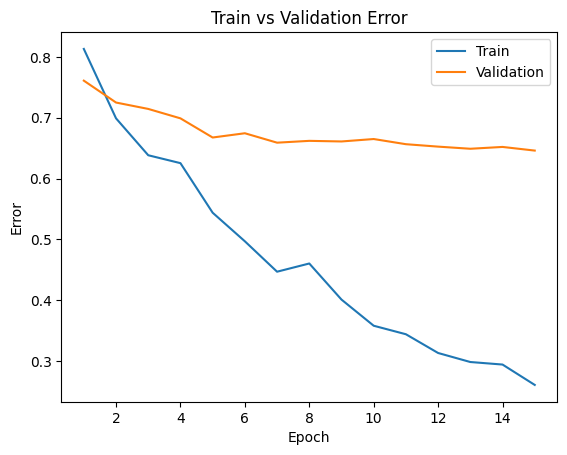

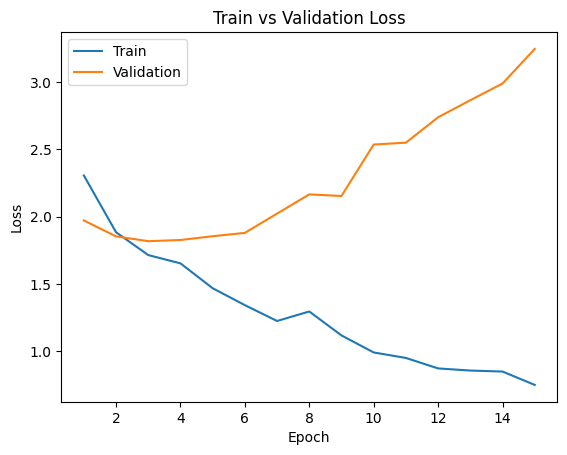

In [9]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
net = BaselineModel().to(device)
train_net(net, "baseline_model", learning_rate=0.01, num_epochs=15)
plot_training_curve("baseline_model")

In [10]:
class AutoEncoder1(nn.Module):
    def __init__(self):
        super(AutoEncoder1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)

        self.conv4 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.conv5 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1)
        self.conv6 = nn.ConvTranspose2d(32, 1, 3, 2, 1, 1)

    def forward(self, x, training=False):
        x_initial = x
        x = self.pool(F.relu(self.conv1(x))) #32x112x112
        x = self.pool(F.relu(self.conv2(x))) #64x56x56
        x = self.pool(F.relu(self.conv3(x))) #128x28x28

        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x)) 
        x = F.relu(self.conv6(x))
        return x


class PrimaryModel2(nn.Module):
    def __init__(self, autoEncoder):
        super(PrimaryModel2, self).__init__()
        self.AE = autoEncoder
        self.AE.requires_grad_(False)

        self.pool = nn.MaxPool2d(2, 2)
        self.conv7 = nn.Conv2d(1, 64, 3, 1, 1)
        # self.bn1 = nn.BatchNorm2d(32)
        self.conv8 = nn.Conv2d(64, 128, 3, 1, 1)
        # self.bn2 = nn.BatchNorm2d(64)
        self.conv9 = nn.Conv2d(128, 256, 3, 1, 1)
        # self.bn3 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(256*28*28, 512)
        # self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x, training=False):
        #x_initial = x
        #x = self.AE(x)
        x = self.pool(F.relu(self.conv7(x))) # + x_initial
        x = self.pool(F.relu(self.conv8(x)))
        x = self.pool(F.relu(self.conv9(x)))
        
        x = x.view(-1, 256*28*28)
        x = F.relu(self.fc1(x)) # self.dropout(F.relu(self.fc1(x)))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [11]:
def train_auto_encoder(net, model_name, dataset_path = FONT_DATASET_PATH, batch_size=128, learning_rate=0.01, num_epochs=30):

    # Create the directory to store model if it does not exist
    if not os.path.exists(model_name):
      os.makedirs(model_name)
    
    # Set the seed for reproducibility
    torch.manual_seed(0)

    # Load the data
    train_loader, val_loader, test_loader, classes = load_dataset(dataset_path, batch_size)
    
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Set up some numpy arrays to store the loss/error rate
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    min_validation_loss= 10000000
    
    print("Starting Training")
    
    # Train the network
    for epoch in range(num_epochs):
        
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            #print(inputs)
            net.train()
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass, backward pass, and optimize
            outputs = net(inputs, training = True)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            net.eval()
            
            # Calculate the statistics
            total_train_loss += loss.item()
            total_epoch += len(labels)
        
        # Store the statistics in the numpy arrays
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_loss[epoch] = evaluate(net, val_loader, criterion, calculate_error = False)

        # Save best model
        if val_loss[epoch] <= min_validation_loss:
            min_validation_loss = val_loss[epoch]
            torch.save(net.state_dict(), f"{model_name}/best_model")
        
        # Print the statistics
        print(f"Epoch {epoch + 1}: Train loss: {train_loss[epoch]} | Validation loss: {val_loss[epoch]}")
        
    
    print('Finished Training')
    net.message="WORKED"

    # Write the loss/err into CSV file for plotting later
    np.savetxt(f"{model_name}/train_loss.csv", train_loss)
    np.savetxt(f"{model_name}/val_loss.csv", val_loss)

In [12]:
print(device)

cuda:0


In [13]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
PM2AutoEncoder = AutoEncoder1().to(device)
train_auto_encoder(PM2AutoEncoder, "AE_1", learning_rate=0.005, num_epochs=30)

Done Loading Data
Starting Training
Epoch 1: Train loss: 0.3160119541782014 | Validation loss: 0.08362582605332136
Epoch 2: Train loss: 0.07526570606104871 | Validation loss: 0.0654325329232961
Epoch 3: Train loss: 0.06306418197903227 | Validation loss: 0.05957683711312711
Epoch 4: Train loss: 0.059859762483454766 | Validation loss: 0.05812587053515017
Epoch 5: Train loss: 0.05823575079124024 | Validation loss: 0.05673685949295759
Epoch 6: Train loss: 0.05694173514208895 | Validation loss: 0.055722798220813274
Epoch 7: Train loss: 0.05579045961828942 | Validation loss: 0.05436112266033888
Epoch 8: Train loss: 0.054936551112443846 | Validation loss: 0.05350868892855942
Epoch 9: Train loss: 0.05431656983304531 | Validation loss: 0.052807841217145324
Epoch 10: Train loss: 0.05325738792406752 | Validation loss: 0.051895976765081286
Epoch 11: Train loss: 0.053618300230579174 | Validation loss: 0.05180638958700001
Epoch 12: Train loss: 0.052283043398502024 | Validation loss: 0.05112530617043

Done Loading Data
Starting Training
Epoch 1: Train err: 0.8213333333333334, Train loss: 2.2487149238586426 | Validation err: 0.7385, Validation loss: 2.1851145774126053
Epoch 2: Train err: 0.683, Train loss: 2.1378361519346845 | Validation err: 0.6715, Validation loss: 2.1124225109815598
Epoch 3: Train err: 0.6141666666666666, Train loss: 2.0705626010894775 | Validation err: 0.624, Validation loss: 2.069769009947777
Epoch 4: Train err: 0.5661666666666667, Train loss: 2.0250255731826132 | Validation err: 0.591, Validation loss: 2.0491004586219788
Epoch 5: Train err: 0.5361666666666667, Train loss: 1.991453467531407 | Validation err: 0.6215, Validation loss: 2.0731049925088882
Epoch 6: Train err: 0.4691666666666667, Train loss: 1.9327161794013166 | Validation err: 0.57, Validation loss: 2.0301017835736275
Epoch 7: Train err: 0.4175, Train loss: 1.8853046716527735 | Validation err: 0.5315, Validation loss: 1.9889656081795692
Epoch 8: Train err: 0.39516666666666667, Train loss: 1.862522541

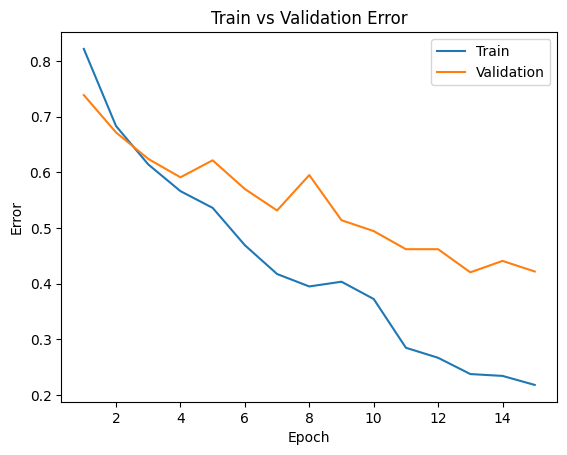

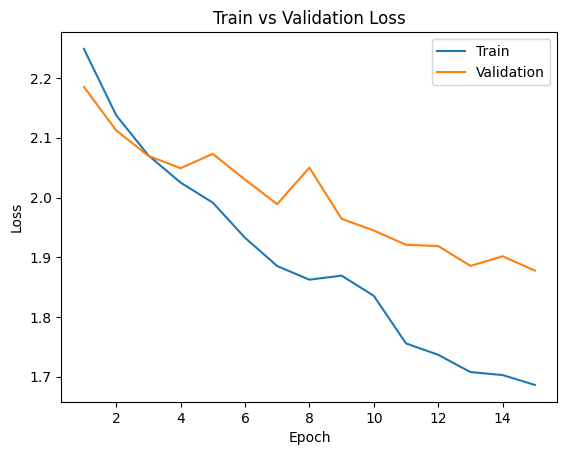

In [14]:
auto_encoder = AutoEncoder1().to(device)
auto_encoder.load_state_dict(torch.load("AE_1\\best_model"))
netPM2 = PrimaryModel2(auto_encoder).to(device)
train_net(netPM2, "primary_model2", learning_rate=0.0005, num_epochs=15, batch_size=128)
plot_training_curve("primary_model2")

In [15]:
print(list(netPM2.AE.parameters())[0][0][0])
auto_encoder = AutoEncoder1()
auto_encoder.load_state_dict(torch.load("AE_1\\best_model"))
print(list(auto_encoder.parameters())[0][0][0])

tensor([[-0.2175,  0.1006, -0.2279],
        [-0.0931, -0.0070,  0.5119],
        [-0.1411,  0.0567, -0.2024]], device='cuda:0')
tensor([[-0.2175,  0.1006, -0.2279],
        [-0.0931, -0.0070,  0.5119],
        [-0.1411,  0.0567, -0.2024]], grad_fn=<SelectBackward0>)
